# Particle Implementation from Liu 2021.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import xlogy

In [28]:
N       = 1000 # number of particles for computing the marginal
dmu     = 2 # dimension of the first target distribution, mu
dnu     = 2 # dimension of the second target distribution, nu
Nx_plot = 19 # spacing for plotting histograms


In [29]:
def sample_mu(K, dmu, sig=0.4,mean_X=0.4):
    '''sample from the distribution mu'''
    out        = np.random.multivariate_normal(mean_X*np.ones(dmu), np.eye(dmu)*sig**2, K)
    out[out<0] = np.random.uniform(0,1,np.sum(out<0))
    out[out>1] = np.random.uniform(0,1,np.sum(out>1))

    return out


def sample_nu(K, dnu,sig=0.4,mean_Y=0.6):
    '''sample from the distribution nu'''
    out        = np.random.multivariate_normal(mean_Y*np.ones(dnu), np.eye(dnu)*sig**2, K)
    out[out<0] = np.random.uniform(0,1,np.sum(out<0))
    out[out>1] = np.random.uniform(0,1,np.sum(out>1))

    return out


def grad_V1(X,sig=0.4,mean_X=0.4):
    '''compute the gradient of the potential V1'''
    gradV1 = (X-mean_X)*np.exp(-np.sum((X-mean_X)**2,axis=-1)[:,np.newaxis]/(2*sig**2))/sig**2
    return gradV1


def grad_V2(Y,sig=0.4,mean_Y=0.6):
    '''compute the gradient of the potential V2'''
    gradV2 = (Y-mean_Y)*np.exp(-np.sum((Y-mean_Y)**2,axis=-1)[:,np.newaxis]/(2*sig**2))/sig**2
    return gradV2


def energy(X,Y,x_hist,y_hist,mu_hist,nu_hist,Lambda,dx,eps=1e-6):
    '''compute the energy of the configuration X,Y'''
    # where x_hist is zero, set to eps
    x_hist[x_hist==0] = eps
    y_hist[y_hist==0] = eps
    coupling_cost = np.sum((X-Y)**2)/N
    entropy_1     = dx**dmu*np.sum(xlogy(mu_hist,mu_hist/x_hist))
    entropy_2     = dx**dnu*np.sum(xlogy(nu_hist,nu_hist/y_hist))
    return coupling_cost + Lambda*(entropy_1 + entropy_2),entropy_1 + entropy_2,coupling_cost

def project_onto_square(X):
    '''project onto the square [0,1]^d'''
    X[X<0] = 0
    X[X>1] = 0.99
    return X


In [31]:
def kernel(x,xi,tau=1):
    '''compute the kernel'''
    return np.exp(-np.sum((x-xi)**2,axis=-1)/(2*tau**2)) 


def nabla_x_kernel(x,xi,tau=1):
    '''compute the gradient of the kernel'''
    return -(x-xi)*kernel(x,xi,tau)[:,:,np.newaxis]  /(tau**2)

In [ ]:
def kernel_grad(X,Y,tau=1.):
    '''compute the gradient of the KL divergence, using the kernel approximation
    tau is the variance of the kernel'''

    X1  = np.repeat(X[:,np.newaxis],N,axis=1)
    X1T = np.transpose(X1,(1,0,2))
    Y1  = np.repeat(Y[:,np.newaxis],N,axis=1)
    Y1T = np.transpose(Y1,(1,0,2))
    
    kernel_outputX = kernel(X1,X1T,tau)   
    grad_kernelX   = nabla_x_kernel(X1,X1T,tau)
    kernel_outputY = kernel(Y1,Y1T,tau)
    grad_kernelY   = nabla_x_kernel(Y1,Y1T,tau)

    gradX =  np.sum(grad_kernelX,axis=1)/np.sum(kernel_outputX,axis=1)[:,np.newaxis]
    gradY =  np.sum(grad_kernelY,axis=1)/np.sum(kernel_outputY,axis=1)[:,np.newaxis]


    gradX += grad_V1(X)
    gradY += grad_V2(Y)

    return gradX,gradY
    

In [ ]:
T = 500
dt = 0.00001
nbreak = 10
Lambda = 100 # weight for the KL divergence, initial condition
energy_history = np.zeros(T)
use_densities = False
tau = 0.005

# initialize the particles as in 2021 Liu paper
X = np.random.uniform(0.25, 0.65, (N,dmu))
Y = np.random.uniform(0.45, 0.85, (N,dnu))
X0 = X.copy()
Y0 = Y.copy()


for tt in tqdm(range(T)):
   
        # use kernel approximation
        gradX,gradY = kernel_grad(X,Y,tau=0.4)
        if tt % 20 == 0:
                print("max value of grad",np.max(Lambda*dt*gradX),np.max(Lambda*dt*gradY))

        noiseX = np.random.normal(0,1,(N,dmu))*np.sqrt(dt)*0.02
        noiseY = np.random.normal(0,1,(N,dnu))*np.sqrt(dt)*0.02

        X -= dt*( (X-Y)+ Lambda*gradX ) + noiseX
        Y -= dt*( (Y-X) + Lambda*gradY) + noiseY

        X = project_onto_square(X)
        Y = project_onto_square(Y)

  0%|          | 1/500 [00:00<02:32,  3.28it/s]

max value of grad 0.00041755797490098366 0.0004337229250520147


  4%|▍         | 21/500 [00:06<02:09,  3.70it/s]

max value of grad 0.00039620835458701475 0.00041049799045185964


  8%|▊         | 41/500 [00:11<02:17,  3.35it/s]

max value of grad 0.00037911562631321615 0.00039155070120693806


 12%|█▏        | 61/500 [00:16<01:54,  3.82it/s]

max value of grad 0.000365627672601896 0.0003765472284329499


 16%|█▌        | 81/500 [00:21<01:45,  3.98it/s]

max value of grad 0.0003560148332747184 0.0003675570031757384


 20%|██        | 101/500 [00:26<01:37,  4.10it/s]

max value of grad 0.00034942093019733146 0.00036375461552826636


 24%|██▍       | 121/500 [00:31<01:37,  3.89it/s]

max value of grad 0.00034508764958269487 0.00036233878301197066


 28%|██▊       | 141/500 [00:37<01:35,  3.78it/s]

max value of grad 0.0003440879573550947 0.00036495759479609856


 32%|███▏      | 161/500 [00:42<01:32,  3.66it/s]

max value of grad 0.0003480373439828769 0.0003711046402249363


 36%|███▌      | 181/500 [00:47<01:23,  3.80it/s]

max value of grad 0.0003535107991646378 0.00038149041275694143


 40%|████      | 201/500 [00:52<01:17,  3.88it/s]

max value of grad 0.00036381790991555377 0.00039559732900924495


 44%|████▍     | 221/500 [00:57<01:10,  3.94it/s]

max value of grad 0.00037650090531281445 0.0004142874925025196


 48%|████▊     | 241/500 [01:03<01:09,  3.71it/s]

max value of grad 0.00039459148441633996 0.0004382137340087746


 52%|█████▏    | 261/500 [01:08<01:00,  3.96it/s]

max value of grad 0.00041877582425512984 0.00046770873131047485


 56%|█████▌    | 281/500 [01:13<00:54,  3.99it/s]

max value of grad 0.00044672167950841527 0.0005038720397206531


 60%|██████    | 301/500 [01:18<00:51,  3.83it/s]

max value of grad 0.00048117022469436544 0.0005474061305784061


 64%|██████▍   | 321/500 [01:24<00:49,  3.62it/s]

max value of grad 0.0005227705069767455 0.0006007680732714947


 68%|██████▊   | 341/500 [01:29<00:47,  3.38it/s]

max value of grad 0.0005756631982243563 0.0006637861817555338


 72%|███████▏  | 361/500 [01:35<00:41,  3.37it/s]

max value of grad 0.0006384960873912276 0.0007410524333625932


 76%|███████▌  | 381/500 [01:41<00:34,  3.48it/s]

max value of grad 0.0007123600395818203 0.0008324022144656947


 80%|████████  | 401/500 [01:47<00:28,  3.50it/s]

max value of grad 0.0008005890975328826 0.000945853777344675


 84%|████████▍ | 421/500 [01:52<00:21,  3.67it/s]

max value of grad 0.0009070905914552096 0.0010841813303786836


 88%|████████▊ | 441/500 [01:58<00:16,  3.59it/s]

max value of grad 0.0010342886911608264 0.0012279134669797476


 92%|█████████▏| 461/500 [02:04<00:11,  3.47it/s]

max value of grad 0.001190053435754809 0.0013677430956438707


 96%|█████████▌| 481/500 [02:09<00:05,  3.65it/s]

max value of grad 0.0013767018492943895 0.0015391864342299928


100%|██████████| 500/500 [02:14<00:00,  3.71it/s]


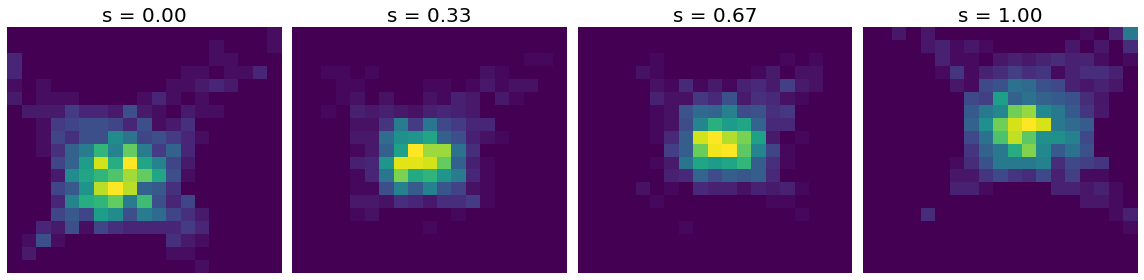

In [ ]:
# plot transport map
n_transport = 4
s = np.linspace(0, 1, n_transport) # this is a transport interpolation

plt.figure(figsize=(4*n_transport, 4))
for i in range(n_transport):
    plt.subplot(1, n_transport, i+1)
    mixed_dist = s[i]*Y + (1-s[i])*X
    plt.hist2d(mixed_dist[:, 0], mixed_dist[:, 1], bins=[np.linspace(0, 1, Nx_plot+1)]*dmu, density=True)
    plt.title('s = %.2f' % s[i], fontsize=20)
    plt.axis("off")
plt.tight_layout()
plt.savefig('transport_map_kernel_method.png')
plt.show()




In [ ]:
# raise ValueError
T = 50
dt = 0.00002
nbreak = 10
Lambda = 100 # weight for the KL divergence, initial condition
energy_history = np.zeros(T)
use_densities = False
tau = 0.005
halfN = int(N/2)

sig = 0.4**2
# initialize the particles using marginals
X1 = np.random.normal(0.4, sig, (halfN,dmu))
Y2 = np.random.normal(0.6, sig, (halfN,dnu))
Y1 = X1 + np.random.normal(0,1,(halfN,dmu))*0.01
X2 = Y2 + np.random.normal(0,1,(halfN,dnu))*0.01
X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])
X0 = X.copy()
Y0 = Y.copy()


for tt in tqdm(range(T)):
   
        # use kernel approximation, only compute for half of the particles
        gradX,gradY = kernel_grad(X,Y,tau=0.45)
        if tt % 20 == 0:
                print("max value of grad",np.max(Lambda*dt*gradX),np.max(Lambda*dt*gradY))

        noiseX = np.random.normal(0,1,(N,dmu))*np.sqrt(dt)*0.05
        noiseY = np.random.normal(0,1,(N,dnu))*np.sqrt(dt)*0.05

        X[halfN:,:] -= dt*( (X-Y)+ Lambda*gradX )[halfN:,:]  + noiseX[halfN:,:]
        Y[:halfN,:] -= dt*( (Y-X) + Lambda*gradY )[:halfN,:] + noiseY[:halfN,:]

        X = project_onto_square(X)
        Y = project_onto_square(Y)

  0%|          | 1/200 [00:00<01:22,  2.41it/s]

max value of grad 0.0025327906689171357 0.0032101470531105923


 10%|█         | 21/200 [00:07<00:57,  3.13it/s]

max value of grad 0.0021348316467810044 0.00323851889800217


 20%|██        | 41/200 [00:13<00:55,  2.85it/s]

max value of grad 0.002072293894324043 0.0033930669872674307


 30%|███       | 61/200 [00:21<00:53,  2.62it/s]

max value of grad 0.002012559015893115 0.003418732476570865


 40%|████      | 81/200 [00:30<00:57,  2.07it/s]

max value of grad 0.0019712603943196198 0.003430509962998829


 50%|█████     | 101/200 [00:38<00:38,  2.60it/s]

max value of grad 0.00236172865227201 0.0034301284957077246


 60%|██████    | 121/200 [00:45<00:25,  3.14it/s]

max value of grad 0.0028328250598925594 0.003428262887520271


 70%|███████   | 141/200 [00:52<00:21,  2.71it/s]

max value of grad 0.002971619284327273 0.0034184416615433352


 80%|████████  | 161/200 [01:00<00:13,  2.80it/s]

max value of grad 0.0029242222561438602 0.003405569694750234


 90%|█████████ | 181/200 [01:07<00:07,  2.71it/s]

max value of grad 0.002921390262672732 0.003388105316657377


100%|██████████| 200/200 [01:13<00:00,  2.71it/s]


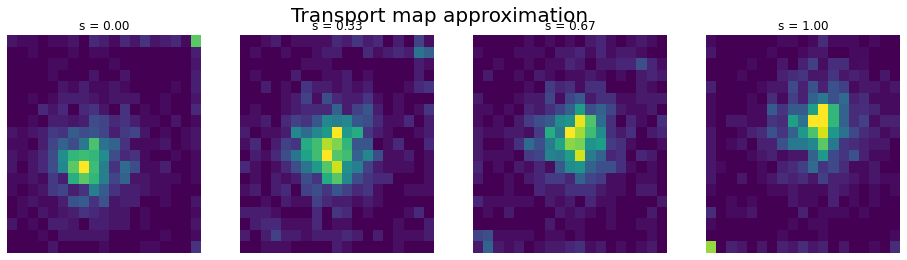

In [ ]:
n_transport = 4
s = np.linspace(0, 1, n_transport) # this is a transport interpolation

plt.figure(figsize=(4*n_transport, 4))
for i in range(n_transport):
    plt.subplot(1, n_transport, i+1)
    mixed_dist = s[i]*Y + (1-s[i])*X
    plt.hist2d(mixed_dist[:, 0], mixed_dist[:, 1], bins=[np.linspace(0, 1, Nx_plot+1)]*dmu, density=True)
    plt.title('s = %.2f' % s[i])
    plt.axis("off")
plt.gcf().suptitle('Transport map approximation', fontsize=20)
plt.show()